# Evaluation of Likelihood using Sequential Monte Carlo

### The particle filter algorithm yields at each step $t$ a weighted sample $(x_t^k, w_t^k)_{k=1}^{N}$ approximating the filtering distribution $p(dx_t|y_{0:t};\theta)$

### The estimators of the marginal liklihood of $\theta$ at time $t$ $$\hat{Z}_t(\theta)=\prod_{s=0}^{t}(\frac{1}{N}\sum_{k=1}^{N}w_s^k)$$

#### p.s:

#### 1.The loaded whisker data is of shape (50,3000), we need to sum it up across axis 0. Then we assume it follows a binomial distribution of N=50.

#### 2.The filtering algorithm in the package returns normalized weights for particle filters, we need to modify it.

In [15]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
sys.path.insert(1,'./code')
from visualize import plot_raw_data, get_population_data, plot_results
from EM import TransformToProb, RunEM
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import pyparticleest.utils.kalman as kalman
from scipy.stats import bernoulli

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


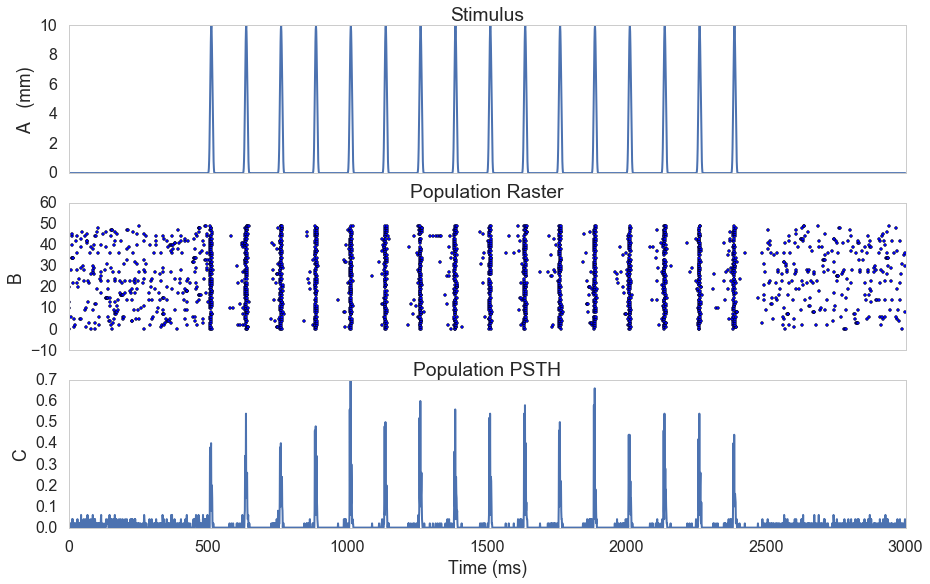

In [27]:
# Get a set of whisker data and plot the raster plot
#path = '/Users/macbookpro/Desktop/Gwungwun/Data/'
path = "/Users/zyzrdfz/Desktop/gwungwun/Data/"
resp_values_1711 = get_population_data(17,1,1, path = path)
#resp_values_1711 = pickle.load(open('/Users/macbookpro/Documents/ss_model_mixture/resp_values_1711.p','rb'))
plot_raw_data(17,1,1,0,figsize=[15,9],path=path)

resp_values_1711 is the loaded whisker data and it's of shape (50,3000), you need to sum it up across axis 0 and then use the data.

In [6]:
print resp_values_1711.shape
Y = np.sum(resp_values_1711, axis = 0)
print Y.shape

(50, 3000)
(3000,)


In [ ]:
# Run EM on the data set and show results
pmode_1711, p_1711, pll_1711, pul_1711, sigma2e_1711 = RunEM(resp_values_1711)
plot_results(resp_values_1711, pmode_1711, p_1711, pll_1711, pul_1711, ylim=[0,0.75])

In [9]:
print sigma2e_1711

0.505904874894


Create a list of sigmas around `sigma2e_1711`.

In [10]:
sigma_ls = np.arange(sigma2e_1711-0.2, sigma2e_1711+0.2,0.01)
print len(sigma_ls)

41


Now evaluate likelikehood using the list of sigmas. Feel free to play around with the list of sigmas and the step sizes.

We use the nlg.NonlinearGaussianInitialGaussian base class and assume y follows a binomial distribution of $N=50$.

In [17]:
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = x_k  + v_k = f(x_k) + v_k,
    # y_k = 0 + e_k = g(x_k) + e_k,
    # x(0) ~ N(0,P0), v_k ~ N(0,Q), e_k ~ Binom(50,\exp(x_{k})/(1+\exp(x_{k})))

    def __init__(self, P0, Q):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q)

    def calc_g(self, particles, t):
    # Calculate value of g(\xi_t,t)
         return np.zeros([len(particles),1])
    
    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        return particles
    
    def measure(self, particles, y, t):
        """
        Return the log-pdf value of the measurement
        Args:
         - particles  (array-like): Model specific representation
           of all particles, with first dimension = N (number of particles)
         - y (array-like):  measurement
         - t (float): time-stamp
        Returns:
         (array-like) with first dimension = N, logp(y|x^i)
        """
        N = len(particles)
#         lpy = np.empty(N)
#         g = self.calc_g(particles=particles, t=t)
 

#         if (g is None):
#             g = np.repeat(self.g.reshape((1, -1, 1)), N, 0)
#         else:
#             g = g.reshape((N, -1, 1))
        yrep = np.repeat(np.asarray(y), N, 0)
    
        lpy = scipy.stats.binom.logpmf(yrep,50,np.exp(particles[:,0])/(1.0 + np.exp(particles[:,0])),loc=0)
    
        return lpy

Let simulator return unnormalized weights

In [4]:
class unnormalizedSimulator(simulator.Simulator):
    def get_filtered_estimates(self):
        """
        Returns type (est, w) (must first have called 'simulate')
         - est: (T, N, D) array containing all particles
         - w: (T,D) array containing all particle weights
        T is the length of the dataset, N is the number of particles and
        D is the dimension of each particle
        """

        T = len(self.pt.traj)
        N = self.pt.traj[0].pa.part.shape[0]
        D = self.pt.traj[0].pa.part.shape[1]

        est = np.empty((T, N, D))

        w = np.empty((T, N))
        
        w_unnormalized = np.empty((T, N))
        
        for t in xrange(T):
            wtmp = np.exp(self.pt.traj[t].pa.w)
            est[t] = self.pt.traj[t].pa.part
            w[t] = wtmp / np.sum(wtmp)
            w_unnormalized[t]=self.pt.traj[t].pa.logw
        return (est, w, w_unnormalized)

In [18]:
#T = 100
#P0 = 0.5 * np.eye(1)
#Q = 0.4 * np.eye(1)

# Forward particles
N = 100
# Backward trajectories
M = 1

In [19]:
#model = StdNonLin(P0, Q)

#sim = unnormalizedSimulator(model, u=None, y=Y)
#sim.simulate(N, M, filter='PF', smoother='full', meas_first=True)

In [20]:

#(est_filt, w_filt) = sim.get_filtered_estimates()
#w_filt.shape
#np.sum(w_filt, axis = 1)/N

In [21]:
#likelihood=np.sum(np.sum(w_filt, axis = 1)/N)
#print likelihood
#loglikelihood=np.sum(np.log(np.sum(w_filt, axis = 1)/N))
#print loglikelihood

In [26]:
sigma_ls = np.arange(0.1, 0.11, 0.1)
print sigma_ls

[ 0.1]


In [23]:
df = pd.read_csv('thaldata.csv',header=None)
Y = df.values.reshape(3000)
#Y = Y[500:800]

In [24]:
T = len(Y)

In [27]:
%%time
%%prun
#likelihood=np.empty(len(sigma_ls))
loglikelihood = np.empty(len(sigma_ls))
logweight = []
www=[]
#repeat = 10
for i in range(len(sigma_ls)):
    print i,
    P0 = sigma_ls[i] * np.eye(1)
    Q = sigma_ls[i] * np.eye(1)
    model = StdNonLin(P0, Q)
    sim = simulator.Simulator(model,u=None,y=Y)
    #sim = unnormalizedSimulator(model, u=None, y=Y)
    sim.simulate(N, M, filter='PF', smoother='ancestor', meas_first=False)
    (est_filt, w_filt) = sim.get_filtered_estimates()
    #logweight = np.reshape(model.lpy,(T,N))
    #weight=np.exp(logweight)
    #maxlogweight = np.max(w_unnormalized,axis=1)
    #weight = np.exp(w_unnormalized - np.reshape(np.repeat(maxlogweight, N),(T, N)))
    www = scipy.stats.binom.pmf(np.reshape(np.repeat(Y,N),[T,N]),50, np.exp(est_filt[1:,:,0])/(1.0 + np.exp(est_filt[1:,:,0])), loc=0)
    loglikelihood[i]=np.sum(np.log(np.sum(www, axis = 1)/N))
    #loglikelihood[i]=np.sum(np.log(np.sum(weight, axis = 1)/N))

0 CPU times: user 1.84 s, sys: 46.1 ms, total: 1.89 s
Wall time: 1.91 s



In [37]:
est_filt[1000,:,0]

array([-10.38001442, -10.16230615,  -9.95751405,  -5.66833228,
        -7.24234434,  -8.0430071 , -12.12634823,  -9.21433253,
        -7.92035616,  -9.27529808,  -7.61189801,  -5.85742551,
        -7.94921305,  -5.9405851 ,  -8.43437117,  -7.3371879 ,
        -6.83699884,  -7.57935614,  -8.7901815 ,  -9.06439473,
        -7.85360535,  -6.86435917,  -6.54992937,  -7.10677368,
        -6.96231117,  -7.54490537, -11.21998117, -12.07302816,
        -5.41451826,  -8.22557986,  -7.44842376,  -6.81519212,
        -9.91096576, -11.93883076,  -8.17284857,  -8.96688561,
        -9.69416844, -10.34159656,  -9.37277996, -10.02822935,
       -10.83521868, -13.6490196 , -12.83852209,  -7.66261899,
        -7.35139839,  -7.94447005,  -7.91660565,  -9.40404192,
        -9.6290806 ,  -8.74580257,  -8.04902587,  -7.50799283,
        -8.28165591,  -6.42252428,  -7.58338375,  -8.23379871,
       -10.08009393, -10.60237011,  -8.49095385,  -7.72159774,
        -7.51182674,  -7.41043301,  -8.28216159,  -5.26

In [122]:
est_filt.shape

(300, 100, 1)

In [ ]:
ll_from_R = np.loadtxt('ll_from_R.txt')

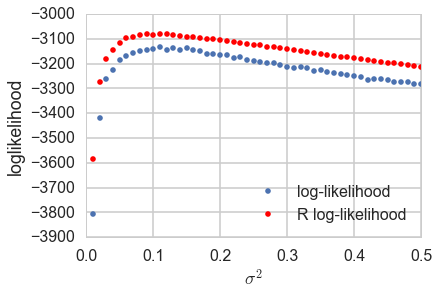

In [298]:
#sigma_ls = np.arange(0.6-0.3, 0.6+0.3+0.01,0.01)
plt.plot(sigma_ls, loglikelihood, '.',linewidth=2.0, label='log-likelihood')
plt.plot(sigma_ls, ll_from_R, 'r.',linewidth=2.0, label='R log-likelihood')
#plt.ylim([-4000,-3500])
plt.ylabel('loglikelihood')
plt.xlabel(r'$\sigma^2$')
plt.legend(loc='best')

The corresponding $\sigma$ of maximum loglikelihood 

In [299]:
sigma_ls[np.argmax(loglikelihood)]

0.11

In [300]:
loglikelihood

array([-3804.22719643, -3419.50075909, -3263.27156676, -3227.16020663,
       -3186.64446484, -3169.11471174, -3155.69957015, -3147.03060652,
       -3143.43078657, -3141.58197787, -3133.17693102, -3146.22291259,
       -3138.71453126, -3143.19647082, -3137.32777593, -3146.4820217 ,
       -3150.79547158, -3159.66516143, -3159.11612289, -3163.95899635,
       -3166.37886052, -3175.26759833, -3175.06103838, -3186.64177744,
       -3189.71578158, -3194.60464476, -3198.53869698, -3198.70939825,
       -3207.30511242, -3212.60525577, -3217.42499195, -3213.22829323,
       -3219.43193954, -3229.54447366, -3227.16655418, -3233.77434419,
       -3238.10137643, -3242.79593892, -3244.91326907, -3248.89429976,
       -3252.15859657, -3264.32016077, -3261.94230867, -3260.3835435 ,
       -3265.00568117, -3273.269917  , -3272.7590158 , -3273.97135266,
       -3283.00292268, -3280.99751651])